In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from torch.distributions import Normal
env = gym.make('InvertedPendulum-v4')

import pickle
from itertools import product
import pandas as pd
import matplotlib as plt

C:\Users\shani\AppData\Local\Temp\ipykernel_15720\3365890419.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        mu = self.actor(x)
        std = self.log_std.exp().expand_as(mu)
        
        value = self.critic(x)
        return mu, std, value

class PPOAgent:
    def __init__(self, input_dim, action_dim, lr=3e-4, gamma=0.99, epsilon=0.2, k_epochs=10, minibatch_size=64, gae_lambda=0.95):
        self.gamma = gamma
        self.epsilon = epsilon
        self.k_epochs = k_epochs
        self.minibatch_size = minibatch_size
        self.gae_lambda = gae_lambda
        self.actor_critic = ActorCritic(input_dim, action_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.mse_loss = nn.MSELoss()

    def select_action(self, state):
        state = torch.from_numpy(state).float()
        mu, std, _ = self.actor_critic(state)
        distribution = torch.distributions.Normal(mu, std)
        action = distribution.sample()
        log_prob = distribution.log_prob(action).sum(dim=-1)
        return action.detach().numpy(), log_prob

    def compute_gae(self, rewards, masks, values, next_value):
        gae = 0
        returns = []
        values = values + [next_value]
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + self.gamma * self.gae_lambda * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

    def update(self, trajectory):
        states, actions, log_probs_old, returns, advantages = trajectory

        log_probs_old = torch.stack(log_probs_old).detach()
        states = torch.stack(states).detach()
        actions = torch.tensor(actions).detach()
        returns = torch.tensor(returns).unsqueeze(-1).detach()
        advantages = torch.tensor(advantages)

        for _ in range(self.k_epochs):
            indices = np.arange(states.shape[0])
            np.random.shuffle(indices)
            for start in range(0, states.shape[0], self.minibatch_size):
                end = start + self.minibatch_size
                minibatch_indices = indices[start:end]
                
                minibatch_states = states[minibatch_indices]
                minibatch_actions = actions[minibatch_indices]
                minibatch_log_probs_old = log_probs_old[minibatch_indices]
                minibatch_returns = returns[minibatch_indices]
                minibatch_advantages = advantages[minibatch_indices]

                mu, std, values = self.actor_critic(minibatch_states)
                dist = torch.distributions.Normal(mu, std)
                log_probs_new = dist.log_prob(minibatch_actions).sum(dim=-1)
                entropy = dist.entropy().mean()

                ratios = torch.exp(log_probs_new - minibatch_log_probs_old)
                surr1 = ratios * minibatch_advantages
                surr2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * minibatch_advantages

                actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy
                critic_loss = self.mse_loss(values, minibatch_returns)

                loss = actor_loss + 0.5 * critic_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def train(self, env, total_episodes=1000, horizon=2048, batch_size=64, reward_save_path='./rewards/rewards_paper.pkl'):
        all_rewards = []

        states, actions, rewards, log_probs, values, masks = [], [], [], [], [], []

        for episode in range(total_episodes):
            state = env.reset()[0]
            episode_rewards = 0

            for _ in range(1000):
                action, log_prob = self.select_action(state)
                value = self.actor_critic(torch.from_numpy(state).float())[-1].item()
                next_state, reward, done, _, _ = env.step(action)

                states.append(torch.from_numpy(state).float())
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                masks.append(1 - done)

                state = next_state
                episode_rewards += reward

                if len(states) % batch_size == 0:
                    next_value = self.actor_critic(torch.from_numpy(state).float())[-1].item()
                    returns = self.compute_gae(rewards, masks, values, next_value)
                    advantages = [ret - val for ret, val in zip(returns, values)]
                    trajectory = (states, actions, log_probs, returns, advantages)
                    self.update(trajectory)

                    states, actions, rewards, log_probs, values, masks = [], [], [], [], [], []

                if done:
                    break

            all_rewards.append(episode_rewards)
            print(f"Episode {episode + 1}, Total Reward = {episode_rewards}")

            # Save rewards after each episode
            with open(reward_save_path, 'wb') as f:
                pickle.dump(all_rewards, f)

        return all_rewards

    def evaluate(self, env, num_episodes=10,nr_steps=1000):
        print("Evaluating")
        total_rewards = 0
        averages = pd.DataFrame(columns=['episode', 'average_reward'])
        all_rewards = []

        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            episode_reward = 0
            ep_rewards = []

            for _ in range(nr_steps):
                state = state[0] if isinstance(state, tuple) else state

                action_numpy, _ = self.select_action(state)
                next_state, reward, done, _, _ = env.step(action_numpy)
                
                state = next_state
                episode_reward += reward

                if done:
                    break
            all_rewards.append(episode_reward)
        #     total_rewards += episode_reward
        #     new_row = pd.DataFrame({'episode': [episode], 'average_reward': [average_reward]})
        #     averages = pd.concat([averages, new_row], ignore_index=True)
        # average_reward = total_rewards / (episode + 1)
        

        return all_rewards

# PPO = PPOAgent(4, 1)
# env = gym.make('InvertedPendulum-v4')   
# rewards = PPO.train(env, total_episodes=10, reward_save_path='./rewards/rewards_2.pkl')
# average_reward, averages = PPO.evaluate(env, num_episodes=10)

# env= gym.make('InvertedPendulum-v4',render_mode='human')
# rewards=0
# state=env.reset()[0]


# action=PPO.select_action(state)[0]
# obs, reward, done, info, _ = env.step(action)
# rewards+=reward
# state=obs
# print(rewards)


In [16]:

def run_experiments(env, param_grid):
    results = []

    for params in param_grid:
        lr, epsilon, k_epochs, discount, batch_size = params
        print(f"Running experiment with lr={lr}, epsilon={epsilon}, k_epochs={k_epochs}, discount={discount},batch_size={batch_size}")

        ppo = PPOAgent(input_dim=4, action_dim=1, lr=lr, epsilon=epsilon, k_epochs=k_epochs, gamma = discount, minibatch_size=batch_size)
        rewards = ppo.train(env, total_episodes=1000)  # Use 1000 episodes for quicker experimentation
        #all_rewards = ppo.evaluate(env, num_episodes=3)
        #print(all_rewards)
        #np_rewards = np.array(all_rewards)
        #avg_reward = np.mean(np_rewards, axis=0)
        
        result = {
            'lr': lr,
            'epsilon': epsilon,
            'k_epochs': k_epochs,
            'discount': discount, 
            'batch_size': batch_size,
            'rewards': rewards,
            'ppo': ppo
        }
        results.append(result)

    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Save DataFrame to a CSV file
    csv_path = './rewards/ex_results_paper.csv'
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    return df


param_grid = list(product(
    [1e-3,1e-4],  # Learning rates
    [0.8,0.5],     # Epsilon values
    [1,5],         # Epochs
    [0.95,0.90],    # discount
    [64]        # Batch sizes
))



df_results_f = run_experiments(env, param_grid)

Running experiment with lr=0.001, epsilon=0.8, k_epochs=1, discount=0.95,batch_size=64
Episode 1, Total Reward = 16.0
Episode 2, Total Reward = 10.0
Episode 3, Total Reward = 14.0
Episode 4, Total Reward = 3.0
Episode 5, Total Reward = 4.0
Episode 6, Total Reward = 15.0
Episode 7, Total Reward = 4.0
Episode 8, Total Reward = 11.0
Episode 9, Total Reward = 7.0
Episode 10, Total Reward = 9.0
Episode 11, Total Reward = 4.0
Episode 12, Total Reward = 10.0
Episode 13, Total Reward = 10.0
Episode 14, Total Reward = 7.0
Episode 15, Total Reward = 6.0
Episode 16, Total Reward = 6.0
Episode 17, Total Reward = 7.0
Episode 18, Total Reward = 7.0
Episode 19, Total Reward = 6.0
Episode 20, Total Reward = 5.0
Episode 21, Total Reward = 7.0
Episode 22, Total Reward = 12.0
Episode 23, Total Reward = 10.0
Episode 24, Total Reward = 5.0
Episode 25, Total Reward = 8.0
Episode 26, Total Reward = 10.0
Episode 27, Total Reward = 8.0
Episode 28, Total Reward = 13.0
Episode 29, Total Reward = 10.0
Episode 30,

In [17]:
df_results = pd.read_csv('./rewards/ex_results_f.csv')
df_results

,lr,epsilon,k_epochs,discount,batch_size,rewards,ppo
0,0.0010,0.8,1,0.95,64,"[16.0, 10.0, 14.0, 3.0, 4.0, 15.0, 4.0, 11.0, ...",<__main__.PPOAgent object at 0x0000018ABBC14EC0>
1,0.0010,0.8,1,0.90,64,"[5.0, 12.0, 7.0, 14.0, 5.0, 9.0, 4.0, 5.0, 8.0...",<__main__.PPOAgent object at 0x0000018ABB7E77A0>
2,0.0010,0.8,5,0.95,64,"[8.0, 9.0, 5.0, 6.0, 14.0, 10.0, 6.0, 5.0, 11....",<__main__.PPOAgent object at 0x0000018ABB622F30>
3,0.0010,0.8,5,0.90,64,"[12.0, 5.0, 11.0, 7.0, 12.0, 8.0, 9.0, 15.0, 1...",<__main__.PPOAgent object at 0x0000018ABB7AAE70>
4,0.0010,0.5,1,0.95,64,"[9.0, 7.0, 6.0, 5.0, 12.0, 14.0, 7.0, 10.0, 8....",<__main__.PPOAgent object at 0x0000018AB96637D0>
5,0.0010,0.5,1,0.90,64,"[18.0, 7.0, 4.0, 6.0, 11.0, 5.0, 5.0, 4.0, 4.0...",<__main__.PPOAgent object at 0x0000018ABB738C20>
6,0.0010,0.5,5,0.95,64,"[10.0, 7.0, 12.0, 12.0, 6.0, 11.0, 21.0, 19.0,...",<__main__.PPOAgent object at 0x0000018AB9663560>
7,0.0010,0.5,5,0.90,64,"[4.0, 14.0, 10.0, 5.0, 14.0, 4.0, 6.0, 13.0, 7...",<__main__.PPOAgent object at 0x0000018AB9663860>
8,0.0001,0.8,1,0.95,64,"[6.0, 5.0, 11.0, 4.0, 7.0, 3.0, 5.0, 5.0, 21.0...",<__main__.PPOAgent object at 0x0000018ABB5AA780>
9,0.0001,0.8,1,0.90,64,"[7.0, 8.0, 4.0, 7.0, 4.0, 11.0, 6.0, 6.0, 11.0...",<__main__.PPOAgent object at 0x0000018ABB58FF20>


# Tial 1: it goes up to 1000 reward really fast

In [24]:

def run_experiments(env, param_grid):
    results = []

    for params in param_grid:
        lr, epsilon, k_epochs, discount, batch_size = params
        print(f"Running experiment with lr={lr}, epsilon={epsilon}, k_epochs={k_epochs}, discount={discount},batch_size={batch_size}")

        ppo = PPOAgent(input_dim=4, action_dim=1, lr=lr, epsilon=epsilon, k_epochs=k_epochs, gamma = discount, minibatch_size=batch_size)
        rewards = ppo.train(env, total_episodes=1000)  # Use 1000 episodes for quicker experimentation
        #all_rewards = ppo.evaluate(env, num_episodes=3)
        #print(all_rewards)
        #np_rewards = np.array(all_rewards)
        #avg_reward = np.mean(np_rewards, axis=0)
        
        result = {
            'lr': lr,
            'epsilon': epsilon,
            'k_epochs': k_epochs,
            'discount': discount, 
            'batch_size': batch_size,
            'rewards': rewards,
            'ppo': ppo
        }
        results.append(result)

    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Save DataFrame to a CSV file
    csv_path = './rewards/ex_results_paper.csv'
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    return df


param_grid_from_paper = list(product(
    [3e-4],  # Learning rates
    [0.1, 0.2, 0.3],     # Epsilon values
    [10],         # Epochs
    [0.99],    # discount
    [64]        # Batch sizes
))

df_results_paper = run_experiments(env, param_grid_from_paper)

Running experiment with lr=0.0003, epsilon=0.1, k_epochs=10, discount=0.99,batch_size=64
Episode 1, Total Reward = 4.0
Episode 2, Total Reward = 5.0
Episode 3, Total Reward = 5.0
Episode 4, Total Reward = 12.0
Episode 5, Total Reward = 9.0
Episode 6, Total Reward = 6.0
Episode 7, Total Reward = 9.0
Episode 8, Total Reward = 13.0
Episode 9, Total Reward = 19.0
Episode 10, Total Reward = 8.0
Episode 11, Total Reward = 6.0
Episode 12, Total Reward = 12.0
Episode 13, Total Reward = 20.0
Episode 14, Total Reward = 8.0
Episode 15, Total Reward = 9.0
Episode 16, Total Reward = 7.0
Episode 17, Total Reward = 9.0
Episode 18, Total Reward = 4.0
Episode 19, Total Reward = 13.0
Episode 20, Total Reward = 5.0
Episode 21, Total Reward = 10.0
Episode 22, Total Reward = 5.0
Episode 23, Total Reward = 6.0
Episode 24, Total Reward = 13.0
Episode 25, Total Reward = 6.0
Episode 26, Total Reward = 19.0
Episode 27, Total Reward = 14.0
Episode 28, Total Reward = 4.0
Episode 29, Total Reward = 9.0
Episode 30,

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Load the data
df = pd.read_csv('./rewards/ex_results_f.csv')
df['last_rewards']=df['rewards'].apply(lambda x: np.mean(ast.literal_eval(x)[-100:]))
df.sort_values(by='last_rewards', ascending=False, inplace=True)
df.head(20)

better_df = df[df['lr'] == 0.001]

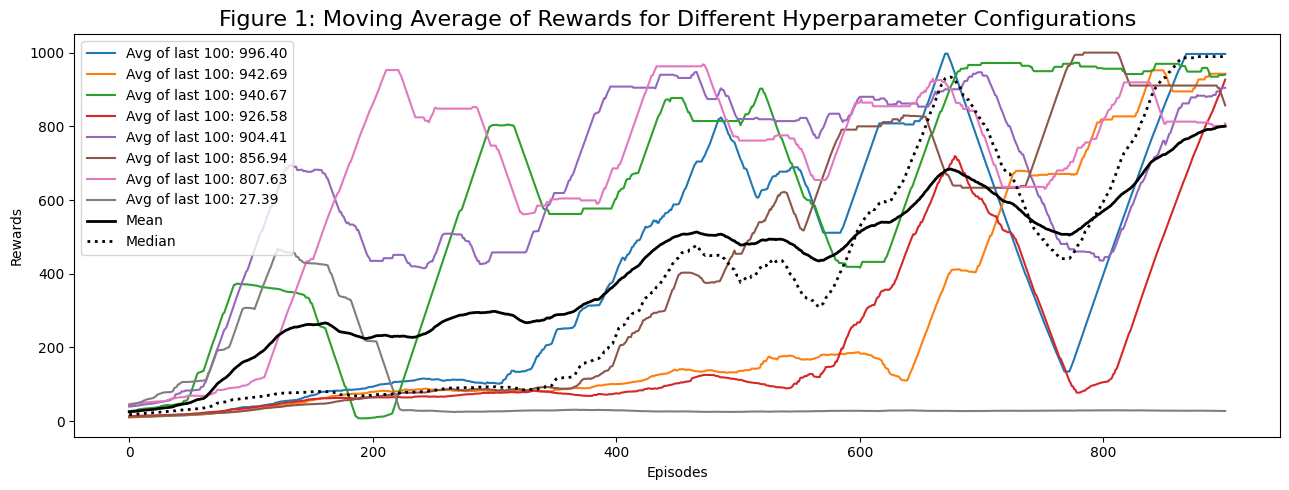

In [45]:

# Create the plot
plt.figure(figsize=(13, 5))
size = 100
# Iterate over each row in the dataframe and plot the rewards
for index, row in better_df.iterrows():
    rewards = ast.literal_eval(row['rewards'])
    avg_rewards = np.mean(rewards[-100:])
    moving_average = np.convolve(rewards, np.ones(size)/size, mode='valid')
    plt.plot(moving_average, label=f'Avg of last 100: {avg_rewards:.2f}')

mean_all_rewards = np.mean([ast.literal_eval(rewards) for rewards in better_df['rewards']], axis=0)
plt.plot(np.convolve(mean_all_rewards, np.ones(size)/size, mode='valid'), label='Mean', color='black', linewidth=2)
median_all_rewards = np.median([ast.literal_eval(rewards) for rewards in better_df['rewards']], axis=0)
plt.plot(np.convolve(median_all_rewards, np.ones(size)/size, mode='valid'), label='Median', linestyle='dotted', color='black', linewidth=2)



# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Figure 1: Moving Average of Rewards for Different Hyperparameter Configurations',fontsize=16)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


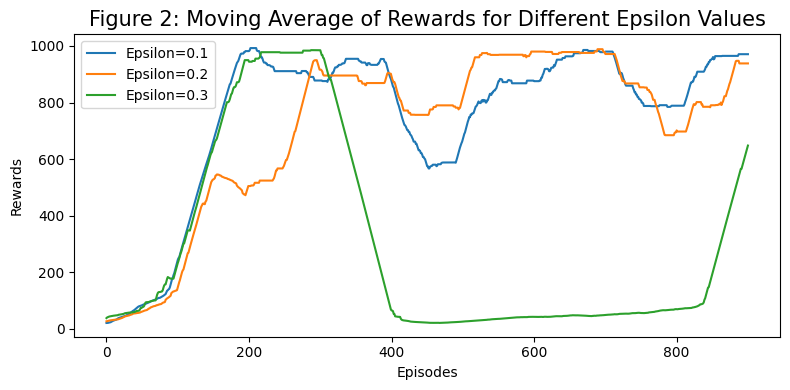

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Load the data
df = pd.read_csv('./rewards/ex_results_paper.csv')

# Create the plot
plt.figure(figsize=(8, 4))
size = 100
# Iterate over each row in the dataframe and plot the rewards
for index, row in df.iterrows():
    rewards = ast.literal_eval(row['rewards'])
    moving_average = np.convolve(rewards, np.ones(size)/size, mode='valid')
    plt.plot(moving_average, label=f'Epsilon={row["epsilon"]}')

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Figure 2: Moving Average of Rewards for Different Epsilon Values',fontsize=15)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
# class ActorCritic(nn.Module):
#     def __init__(self, state_dim, action_dim, hidden_size=64):
#         super(ActorCritic, self).__init__()
#         self.actor = nn.Sequential(
#             nn.Linear(state_dim, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, action_dim)
#         )
#         self.critic = nn.Sequential(
#             nn.Linear(state_dim, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, 1)
#         )
#         self.log_std = nn.Parameter(torch.zeros(action_dim))

#     def forward(self, x):
#         mu = self.actor(x)
#         std = self.log_std.exp().expand_as(mu)
        
#         value = self.critic(x)
#         return mu, std, value

# class PPOAgent:
#     def __init__(self, input_dim, action_dim, lr=3e-4, gamma=0.99, epsilon=0.2, k_epochs=10, minibatch_size=64, gae_lambda=0.95):
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.k_epochs = k_epochs
#         self.minibatch_size = minibatch_size
#         self.gae_lambda = gae_lambda
#         self.actor_critic = ActorCritic(input_dim, action_dim)
#         self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
#         self.mse_loss = nn.MSELoss()

#     def select_action(self, state):
#         state = torch.from_numpy(state).float()
#         mu, std, _ = self.actor_critic(state)
#         distribution = torch.distributions.Normal(mu, std)
#         action = distribution.sample()
#         log_prob = distribution.log_prob(action).sum(dim=-1)
#         return action.detach().numpy(), log_prob

#     def compute_gae(self, rewards, masks, values, next_value):
#         gae = 0
#         returns = []
#         values = values + [next_value]
#         for step in reversed(range(len(rewards))):
#             delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
#             gae = delta + self.gamma * self.gae_lambda * masks[step] * gae
#             returns.insert(0, gae + values[step])
#         return returns

#     def update(self, trajectory):
#         states, actions, log_probs_old, returns, advantages = trajectory

#         log_probs_old = torch.stack(log_probs_old).detach()
#         states = torch.stack(states).detach()
#         actions = torch.tensor(actions).detach()
#         returns = torch.tensor(returns).unsqueeze(-1).detach()
#         advantages = torch.tensor(advantages)

#         for _ in range(self.k_epochs):
#             indices = np.arange(states.shape[0])
#             np.random.shuffle(indices)
#             for start in range(0, states.shape[0], self.minibatch_size):
#                 end = start + self.minibatch_size
#                 minibatch_indices = indices[start:end]
                
#                 minibatch_states = states[minibatch_indices]
#                 minibatch_actions = actions[minibatch_indices]
#                 minibatch_log_probs_old = log_probs_old[minibatch_indices]
#                 minibatch_returns = returns[minibatch_indices]
#                 minibatch_advantages = advantages[minibatch_indices]

#                 mu, std, values = self.actor_critic(minibatch_states)
#                 dist = torch.distributions.Normal(mu, std)
#                 log_probs_new = dist.log_prob(minibatch_actions).sum(dim=-1)
#                 entropy = dist.entropy().mean()

#                 ratios = torch.exp(log_probs_new - minibatch_log_probs_old)
#                 surr1 = ratios * minibatch_advantages
#                 surr2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * minibatch_advantages

#                 actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy
#                 critic_loss = self.mse_loss(values, minibatch_returns)

#                 loss = actor_loss + 0.5 * critic_loss

#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()

#     def train(self, env, total_episodes=1000000, horizon=2048, batch_size=64):
#         all_rewards = []

#         states, actions, rewards, log_probs, values, masks = [], [], [], [], [], []

#         for episode in range(total_episodes):
#             state = env.reset()[0]
#             episode_rewards = 0

#             for _ in range(1000):
#                 action, log_prob = self.select_action(state)
#                 value = self.actor_critic(torch.from_numpy(state).float())[-1].item()
#                 next_state, reward, done, _, _ = env.step(action)

#                 states.append(torch.from_numpy(state).float())
#                 actions.append(action)
#                 rewards.append(reward)
#                 log_probs.append(log_prob)
#                 values.append(value)
#                 masks.append(1 - done)

#                 state = next_state
#                 episode_rewards += reward
                

#                 if len(states) % batch_size == 0:
#                     next_value = self.actor_critic(torch.from_numpy(state).float())[-1].item()
#                     returns = self.compute_gae(rewards, masks, values, next_value)
#                     advantages = [ret - val for ret, val in zip(returns, values)]
#                     trajectory = (states, actions, log_probs, returns, advantages)
#                     self.update(trajectory)

#                     states, actions, rewards, log_probs, values, masks = [], [], [], [], [], []

#                 if done:
#                     break

#             all_rewards.append(episode_rewards)
#             print(f"Episode {episode + 1}, Total Reward = {episode_rewards}")


#         return all_rewards
    
#     def evaluate(self, env, num_episodes=1000):
#         total_rewards = 0
#         for _ in range(num_episodes):
#             state = env.reset()
#             done = False
#             episode_reward = 0

#             while not done:
#                 state = state[0] if isinstance(state, tuple) else state
                
#                 state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state array to tensor
               
#                 mu, std, values = self.actor_critic(state_tensor)
#                 dist = torch.distributions.Normal(mu, std)
#                 action = dist.sample()
               
#                 # Ensure action remains a 1-dimensional array with a single element
#                 action_numpy = action.squeeze().detach().numpy()  # Squeeze to potentially reduce dimensions
#                 if action_numpy.ndim == 0:  # If the result is a scalar, convert it back to an array
#                     action_numpy = np.array([action_numpy])
                
#                 next_state, reward, done, _, _ = env.step(action_numpy)
#                 state = next_state
#                 episode_reward += reward

#             total_rewards += episode_reward

#         average_reward = total_rewards / num_episodes
#         return average_reward

# # Initialize PPOAgent and train
# ppo = PPOAgent(4, 1)
# env = gym.make('InvertedPendulum-v4')
# #rewards = ppo.train(env, total_episodes=10000, horizon=2048, batch_size=64)




In [11]:
# def run_experiments(env, param_grid):
#     results = []

#     for params in param_grid:
#         print(f"Running experiment with parameters: {params+1}")
#         lr, epsilon, k_epochs, batch_size = params
#         print(f"Running experiment with lr={lr}, epsilon={epsilon}, k_epochs={k_epochs}, batch_size={batch_size}")

#         ppo = PPOAgent(input_dim=4, action_dim=1, lr=lr, epsilon=epsilon, k_epochs=k_epochs, minibatch_size=batch_size)
#         rewards = ppo.train(env, total_episodes=1000)  # Reduce the number of episodes for quicker experimentation
#         avg_reward = ppo.evaluate(env)
        
#         result = {
#             'lr': lr,
#             'epsilon': epsilon,
#             'k_epochs': k_epochs,
#             'batch_size': batch_size,
#             'average_reward': avg_reward,
#             'rewards': rewards
#         }
#         results.append(result)

#         with open('./rewards/experiment_results_trial_1.pkl', 'wb') as f:
#             pickle.dump(results, f)

#     return results

# Define the parameter grid
# param_grid = list(product(
#     [3e-4, 1e-3],  # Learning rates
#     [0.1, 0.2, 0.3],     # Epsilon values
#     [5, 10, 20],         # Epochs
#     [32, 64]        # Batch sizes
# ))



TypeError: can only concatenate tuple (not "int") to tuple

# Trial 2: might be more correct, changed, so it saves total reward per epsiode:

In [ ]:
#in results 1 i ran all in range 100


#in results 2 i ran in range 1000 for train and 100 for eval

,lr,epsilon,k_epochs,batch_size,average_reward,rewards
0,0.0001,0.1,5,32,10.0,"[6.0, 10.0, 4.0, 8.0, 9.0, 5.0, 7.0, 6.0, 10.0..."
1,0.0001,0.1,5,64,10.0,"[8.0, 10.0, 10.0, 6.0, 10.0, 10.0, 6.0, 10.0, ..."
2,0.0001,0.1,5,128,10.0,"[6.0, 6.0, 10.0, 4.0, 9.0, 4.0, 4.0, 9.0, 8.0,..."
3,0.0001,0.1,10,32,10.0,"[3.0, 10.0, 5.0, 4.0, 10.0, 4.0, 10.0, 6.0, 10..."
4,0.0001,0.1,10,64,10.0,"[6.0, 4.0, 10.0, 5.0, 6.0, 4.0, 5.0, 6.0, 6.0,..."
...,...,...,...,...,...,...
76,0.0010,0.3,10,64,10.0,"[10.0, 10.0, 10.0, 5.0, 8.0, 7.0, 5.0, 6.0, 4...."
77,0.0010,0.3,10,128,10.0,"[7.0, 10.0, 10.0, 8.0, 8.0, 5.0, 10.0, 4.0, 9...."
78,0.0010,0.3,20,32,10.0,"[6.0, 8.0, 9.0, 5.0, 3.0, 8.0, 10.0, 4.0, 8.0,..."
79,0.0010,0.3,20,64,10.0,"[10.0, 10.0, 5.0, 6.0, 9.0, 5.0, 10.0, 9.0, 7...."


In [ ]:
import matplotlib.pyplot as plt
def plot_rewards(rewards, title='Rewards'):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, color='blue')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os
from itertools import product

def plot_rewards_1(param_grid, file_template='rewards_lr_{lr}_epsilon_{epsilon}_k_epochs_{k_epochs}_batch_size_{batch_size}.pkl', interval=100):
    plt.figure(figsize=(10, 6))

    for params in param_grid:
        lr, epsilon, k_epochs, batch_size = params
        file_name = "./rewards/"+file_template.format(lr=lr, epsilon=epsilon, k_epochs=k_epochs, batch_size=batch_size)
        
        if os.path.exists(file_name):
            with open(file_name, 'rb') as f:
                rewards = pickle.load(f)
            
            # Calculate average rewards over intervals
            avg_rewards = [sum(rewards[i:i + interval]) / interval for i in range(0, len(rewards), interval)]
            
            label = f'LR={lr}, ε={epsilon}, Epochs={k_epochs}, Batch={batch_size}'
            plt.plot(range(0, len(rewards), interval), avg_rewards, label=label)
        else:
            print(f"File {file_name} not found. Skipping...")

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards vs Episodes for Different Hyperparameters')
    plt.legend()
    plt.grid(True)
    plt.show()

# Condensed parameter grid
param_grid = list(product(
    [1e-4, 1e-3],       # Learning rates
    [0.1, 0.3],         # Epsilon values
    [5, 20],            # Epochs
    [32, 128]           # Batch sizes
))

# Plot the rewards
plot_rewards_1(param_grid)


In [ ]:
def plot_rewards()

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os
from itertools import product

def plot_rewards_2(param_grid, file_template='rewards_lr_{lr}_epsilon_{epsilon}_k_epochs_{k_epochs}_batch_size_{batch_size}.pkl', interval=10000):
    num_params = len(param_grid)
    num_cols = 4
    num_rows = (num_params + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharex=True, sharey=True)
    axs = axs.flatten()

    for idx, params in enumerate(param_grid):
        lr, epsilon, k_epochs, batch_size = params
        file_name = "./rewards/" + file_template.format(lr=lr, epsilon=epsilon, k_epochs=k_epochs, batch_size=batch_size)
        
        if os.path.exists(file_name):
            with open(file_name, 'rb') as f:
                rewards = pickle.load(f)
            
            # Calculate average rewards over intervals
            avg_rewards = [sum(rewards[i:i + interval]) / interval for i in range(0, len(rewards), interval)]
            
            label = f'LR={lr}, ε={epsilon}, Epochs={k_epochs}, Batch={batch_size}'
            axs[idx].plot(range(0, len(rewards), interval), avg_rewards, label=label)
            axs[idx].set_title(label)
            axs[idx].legend(loc='best')
        else:
            axs[idx].set_title('File not found')
            axs[idx].plot([])  # Add an empty plot to keep the subplot layout consistent

    # Hide any empty subplots
    for idx in range(len(param_grid), len(axs)):
        axs[idx].set_visible(False)

    for ax in axs:
        ax.set_xlabel('Episode')
        ax.set_ylabel('Total Reward')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Define the parameter grid
param_grid = list(product(
    [1e-4, 3e-4, 1e-3],  # Learning rates
    [0.1, 0.2, 0.3],     # Epsilon values
    [5, 10, 20],         # Epochs
    [32, 64, 128]        # Batch sizes
))

# Plot the rewards
plot_rewards_2(param_grid)
